# Understanding GANs

Imagine walking into an art studio where something fascinating is happening: there's an artist and an art critic engaged in an unusual competition. The artist is trying to create paintings that look exactly like works from a famous gallery, while the critic's job is to spot the difference between real gallery paintings and the artist's creations. This back-and-forth between artist and critic perfectly captures how GANs (Generative Adversarial Networks) work.

## Core Intuition 

In our Swiss Roll example, we can think of it this way: The artist (Generator) is trying to create points that form the distinctive spiral pattern of a Swiss Roll, while the critic (Discriminator) needs to distinguish between points from the real Swiss Roll distribution and the artist's generated points. Through this competition, both networks improve – the artist gets better at creating realistic points, and the critic becomes more discerning.

## The Mathematical Dance 

This artistic competition translates into a mathematical game. The Generator (G) and Discriminator (D) play what we call a minimax game, represented by this equation:

$$
\min_G \max_D \mathbb{E}_{x}[\log D(x)] + \mathbb{E}_{z}[\log(1 - D(G(z)))]
$$

Breaking this down in simple terms:

- D(x) is the critic's judgment of real data (should be close to 1)
- G(z) is the artist creating new data from random noise z
- D(G(z)) is the critic's judgment of generated data (should be close to 0)
- The Generator tries to minimize this difference
- The Discriminator tries to maximize it

<!-- 

Unlike other generative models we've seen:

- VAEs work like photographers who compress and reconstruct images
- Flow Matching works like a choreographer planning smooth movements
- GANs work like artists learning through feedback and competition

This competitive approach often leads to:

1. Sharper, more realistic outputs
2. No need for explicit probability calculations
3. Direct optimization of generation quality -->

### The Latent Space (potential homework? to explore)

The noise input to our Generator isn't just random numbers – it's a structured space where:

- Similar points generate similar outputs
- We can interpolate between points
- Different dimensions might control different features

## Key Papers 
For a deeper dive into GANs, consider reading:

* "Generative Adversarial Networks" by Goodfellow et al. (2014)
* "Wasserstein GAN" by Arjovsky et al. (2017)


Training GAN: 100%|██████████| 10000/10000 [07:29<00:00, 22.25it/s, G_Loss=0.817, D_Loss=1.29]


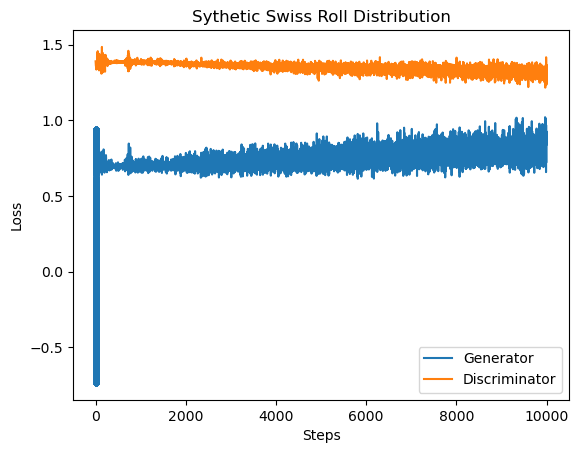

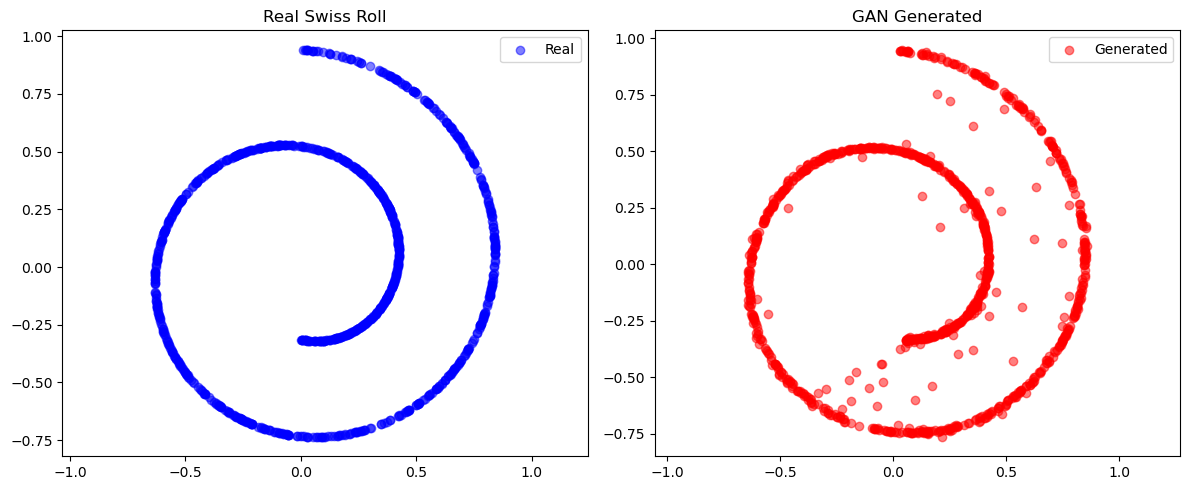

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


# Generate Swiss Roll data (same as before)
def generate_swiss_roll(n_samples=1000):
    """
    Generate 2D Swiss Roll data points
    Args:
        n_samples: Number of points to generate
    Returns:
        torch.Tensor of shape (n_samples, 2)
    """
    t = 1.5 * np.pi * (1 + 2 * torch.rand(n_samples))
    x = t * torch.cos(t)
    y = t * torch.sin(t)
    data = torch.stack([x, y], dim=1) / 15.0  # Scale down the data
    return data


data = generate_swiss_roll(n_samples=10000)
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10)
plt.title("Sythetic Swiss Roll Distribution")


class Generator(nn.Module):
    """
    Generator network that transforms random noise into 2D points
    to mimic the Swiss Roll distribution
    """

    def __init__(self, latent_dim=2, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 2),  # Output 2D coordinates
            nn.Tanh(),  # Bound outputs to [-1, 1]
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    """
    Discriminator network that tries to distinguish real Swiss Roll points
    from generated ones
    """

    def __init__(self, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),  # Output probability between 0 and 1
        )

    def forward(self, x):
        return self.net(x)


def train_gan(n_steps=10000, batch_size=128, lr=2e-4, latent_dim=2):
    """
    Train the GAN on Swiss Roll data
    Args:
        n_steps: Number of training steps
        batch_size: Batch size for training
        lr: Learning rate
        latent_dim: Dimension of noise input to generator
    Returns:
        Trained generator and discriminator models, training losses, device
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize networks and optimizers
    generator = Generator(latent_dim=latent_dim).to(device)
    discriminator = Discriminator().to(device)

    # Use Adam optimizer with beta parameters recommended for GANs
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(
        discriminator.parameters(), lr=lr, betas=(0.5, 0.999)
    )

    criterion = nn.BCELoss()

    # Training loop
    g_losses, d_losses = [], []
    pbar = tqdm(range(n_steps), desc="Training GAN")

    for step in pbar:
        # Train Discriminator
        for _ in range(1):  # Can adjust D/G training ratio
            # Real data
            real_data = generate_swiss_roll(batch_size).to(device)
            real_labels = torch.ones(batch_size, 1).to(device)

            # Generated data
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z).detach()
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train on real and fake data
            d_optimizer.zero_grad()
            d_real_loss = criterion(discriminator(real_data), real_labels)
            d_fake_loss = criterion(discriminator(fake_data), fake_labels)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

        # Train Generator
        for _ in range(1):
            z = torch.randn(batch_size, latent_dim).to(device)
            g_optimizer.zero_grad()
            fake_data = generator(z)
            g_loss = criterion(discriminator(fake_data), real_labels)  # Try to fool D
            g_loss.backward()
            g_optimizer.step()

        # Record losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if step % 100 == 0:
            pbar.set_postfix({"G_Loss": g_loss.item(), "D_Loss": d_loss.item()})

    return generator, discriminator, g_losses, d_losses, device


# Train the model
generator, discriminator, g_losses, d_losses, device = train_gan()

# Plot training losses
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


def visualize_gan_samples(generator, n_samples=1000):
    """
    Visualize samples from the trained generator alongside real data
    Args:
        generator: Trained generator model
        n_samples: Number of points to generate
    """
    device = next(generator.parameters()).device

    # Generate samples
    with torch.no_grad():
        z = torch.randn(n_samples, 2).to(device)
        fake_data = generator(z).cpu().numpy()

    # Get real data for comparison
    real_data = generate_swiss_roll(n_samples).numpy()

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(real_data[:, 0], real_data[:, 1], c="blue", alpha=0.5, label="Real")
    plt.title("Real Swiss Roll")
    plt.legend()
    plt.axis("equal")

    plt.subplot(1, 2, 2)
    plt.scatter(fake_data[:, 0], fake_data[:, 1], c="red", alpha=0.5, label="Generated")
    plt.title("GAN Generated")
    plt.legend()
    plt.axis("equal")

    plt.tight_layout()
    plt.show()


# Visualize results
visualize_gan_samples(generator)


# Generative Adversarial Network (GAN) for Swiss Roll Data

In this notebook you will implement—in part—the training loop for a GAN on a 2D Swiss Roll dataset.

**Overview:**

- **Generator:**  
  Transforms random noise into 2D points that mimic the Swiss Roll data.

- **Discriminator:**  
  Distinguishes real Swiss Roll points from those generated by the generator.

- **Training Objectives:**  
  - **Discriminator:** Maximize the probability of assigning correct labels to real and fake samples.
  - **Generator:** Fool the discriminator by generating samples that are labeled as real.

**Your Task:**  
Review and complete the GAN training loop. In particular, you will work on the part where:
  - Real and fake labels are created.
  - The discriminator loss is computed on real data (with true labels) and on fake data (with fake labels).
  - The generator loss is computed by trying to convince the discriminator that generated samples are real.

Study the provided hints and inline comments carefully.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim  # Import the optimizer module
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility.
torch.manual_seed(42)
np.random.seed(42)

## Data Generation

We define a function to generate 2D Swiss Roll data points. This will serve as our real data distribution.


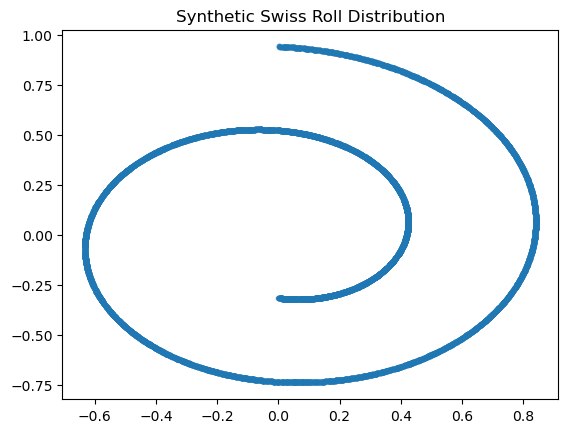

In [4]:
def generate_swiss_roll(n_samples=1000):
    """
    Generate 2D Swiss Roll data points.

    Args:
        n_samples: Number of points to generate.

    Returns:
        torch.Tensor of shape (n_samples, 2)
    """
    t = 1.5 * np.pi * (1 + 2 * torch.rand(n_samples))
    x = t * torch.cos(t)
    y = t * torch.sin(t)
    data = torch.stack([x, y], dim=1) / 15.0  # Scale down the data
    return data


# Visualize some Swiss Roll data.
data = generate_swiss_roll(n_samples=10000)
plt.scatter(data[:, 0].detach().numpy(), data[:, 1].detach().numpy(), alpha=0.5, s=10)
plt.title("Synthetic Swiss Roll Distribution")
plt.show()

## Network Architectures

Below are the Generator and Discriminator network definitions.

- **Generator:**  
  Takes a latent noise vector and outputs a 2D sample.  
  The final Tanh activation bounds outputs to $[-1,1]$.

- **Discriminator:**  
  Takes a 2D input and outputs a scalar probability (after Sigmoid) indicating whether the input is real.


In [5]:
class Generator(nn.Module):
    """
    Generator network that transforms random noise into 2D points
    to mimic the Swiss Roll distribution.
    """

    def __init__(self, latent_dim=2, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 2),  # Output 2D coordinates
            nn.Tanh(),  # Bound outputs to [-1, 1]
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    """
    Discriminator network that tries to distinguish real Swiss Roll points
    from generated ones.
    """

    def __init__(self, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),  # Output probability between 0 and 1.
        )

    def forward(self, x):
        return self.net(x)

## GAN Training Loop

In this cell you'll write the training loop for the GAN. Pay close attention to the following steps:

1. **Discriminator Training:**
   - **Real Data:**  
     Sample a batch of real Swiss Roll points and assign them the label 1.
   - **Fake Data:**  
     Sample random noise, generate fake points with the Generator, and assign them the label 0.
   - **Discriminator Loss:**  
     Compute the Binary Cross Entropy (BCE) loss for both real and fake samples and sum them.
     
2. **Generator Training:**
   - Generate fake data from random noise.
   - Compute the generator loss by passing the fake samples through the discriminator and  
     comparing them to the true label (1) because the generator wants to fool the discriminator.
     
**TODO:**  
Implement (or study and understand) the loss calculations for both generator and discriminator.  
Check that:
- The discriminator uses correct true labels for real data (`1`) and fake data (`0`).
- The generator is trained with fake data but with the target label set to `1`.
  
HINTS are provided in the inline comments.

In [6]:
def train_gan(n_steps=10000, batch_size=128, lr=2e-4, latent_dim=2):
    """
    Train the GAN on Swiss Roll data.

    Args:
        n_steps (int): Number of training steps.
        batch_size (int): Batch size for training.
        lr (float): Learning rate.
        latent_dim (int): Dimension of the noise input for the generator.

    Returns:
        generator, discriminator, g_losses, d_losses, device
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize networks.
    generator = Generator(latent_dim=latent_dim).to(device)
    discriminator = Discriminator().to(device)

    # Set up optimizers with recommended beta parameters for GAN training.
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(
        discriminator.parameters(), lr=lr, betas=(0.5, 0.999)
    )

    # Define the binary cross-entropy loss function.
    criterion = nn.BCELoss()

    # Containers for losses.
    g_losses, d_losses = [], []

    from tqdm import tqdm  # Ensures that tqdm is imported if not already.

    pbar = tqdm(range(n_steps), desc="Training GAN")

    for step in pbar:
        # ------------------ Train Discriminator ------------------
        for _ in range(1):
            # Sample a batch of real data.
            real_data = generate_swiss_roll(batch_size).to(device)
            real_labels = torch.ones(batch_size, 1, device=device)  # Real labels are 1.

            # Sample noise from the latent distribution and generate fake data.
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_data = generator(
                z
            ).detach()  # Detach to avoid backprop into generator.
            fake_labels = torch.zeros(
                batch_size, 1, device=device
            )  # Fake labels are 0.

            # Zero the gradients for discriminator.
            d_optimizer.zero_grad()

            # Forward pass through the discriminator.
            real_preds = discriminator(real_data)
            fake_preds = discriminator(fake_data)

            # Compute discriminator loss:
            #   1. Use your chosen criterion on (real_preds, real_labels) to calculate the loss for real samples.
            #   2. Do the same for fake samples with (fake_preds, fake_labels).
            #   3. Sum or average these two losses appropriately.
            # Replace the following line with your implementation.

            d_real_loss = criterion(real_preds, real_labels)
            d_fake_loss = criterion(fake_preds, fake_labels)
            d_loss = d_real_loss + d_fake_loss

            d_loss.backward()
            d_optimizer.step()

        # ------------------ Train Generator ------------------
        for _ in range(1):
            # Sample noise to generate fake data.
            z = torch.randn(batch_size, latent_dim, device=device)
            g_optimizer.zero_grad()
            fake_data = generator(z)

            # Compute the generator loss:
            #   1. Pass fake_data through the discriminator.
            #   2. Compare the output with real labels (ones) because the generator's goal is to fool the discriminator.
            # Replace the following line with your implementation.

            g_loss = criterion(fake_preds, real_labels)

            g_loss.backward()
            g_optimizer.step()

        # Record losses.
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if step % 100 == 0:
            pbar.set_postfix({"G_Loss": g_loss.item(), "D_Loss": d_loss.item()})

    return generator, discriminator, g_losses, d_losses, device


# Train the GAN.
generator, discriminator, g_losses, d_losses, device = train_gan()

# %% [code]
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("GAN Training Loss")
plt.legend()
plt.show()

Training GAN:   0%|          | 0/10000 [00:00<?, ?it/s]

Training GAN:   0%|          | 0/10000 [00:00<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

## Visualizing GAN Results

Finally, we visualize samples generated from the trained generator alongside real Swiss Roll data.

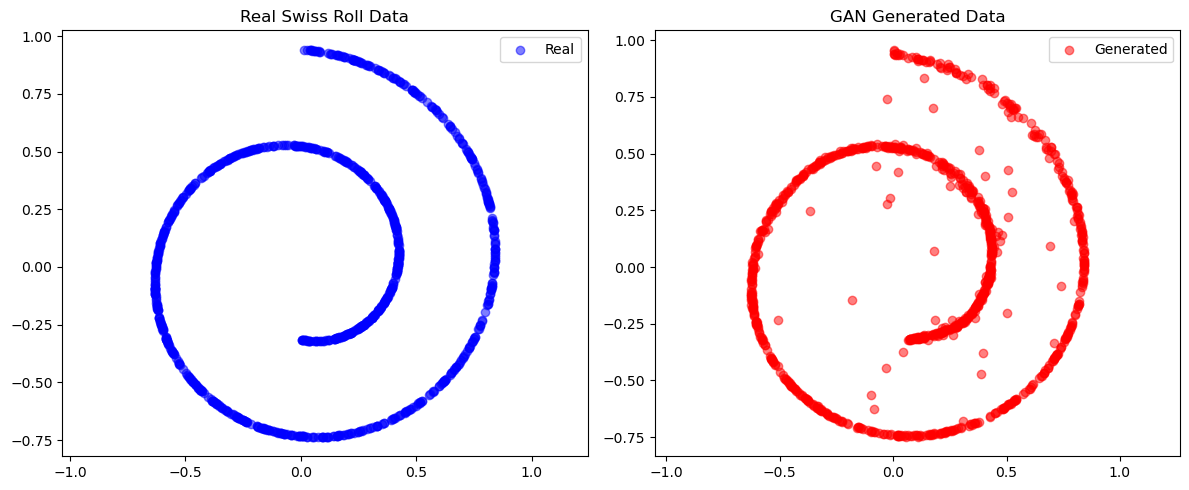

In [ ]:
def visualize_gan_samples(generator, n_samples=1000):
    """
    Visualize samples from the generator along with real data.

    Args:
        generator: Trained generator model.
        n_samples: Number of samples to generate.
    """
    device = next(generator.parameters()).device

    with torch.no_grad():
        # Generate fake samples.
        z = torch.randn(n_samples, 2, device=device)
        fake_data = generator(z).cpu().numpy()

    # Get real data for comparison.
    real_data = generate_swiss_roll(n_samples).numpy()

    # Create side-by-side plots.
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(real_data[:, 0], real_data[:, 1], c="blue", alpha=0.5, label="Real")
    plt.title("Real Swiss Roll Data")
    plt.legend()
    plt.axis("equal")

    plt.subplot(1, 2, 2)
    plt.scatter(fake_data[:, 0], fake_data[:, 1], c="red", alpha=0.5, label="Generated")
    plt.title("GAN Generated Data")
    plt.legend()
    plt.axis("equal")

    plt.tight_layout()
    plt.show()


# Visualize the generated results.
visualize_gan_samples(generator)

# Extra Resource for Reference
## Understanding GANs

Imagine walking into an art studio where something fascinating is happening: there's an artist and an art critic engaged in an unusual competition. The artist is trying to create paintings that look exactly like works from a famous gallery, while the critic's job is to spot the difference between real gallery paintings and the artist's creations. This back-and-forth between artist and critic perfectly captures how GANs (Generative Adversarial Networks) work.

## Core Intuition 

In our Swiss Roll example, we can think of it this way: The artist (Generator) is trying to create points that form the distinctive spiral pattern of a Swiss Roll, while the critic (Discriminator) needs to distinguish between points from the real Swiss Roll distribution and the artist's generated points. Through this competition, both networks improve – the artist gets better at creating realistic points, and the critic becomes more discerning.

## The Mathematical Dance 

This artistic competition translates into a mathematical game. The Generator (G) and Discriminator (D) play what we call a minimax game, represented by this equation:

$$
\min_G \max_D \mathbb{E}_{x}[\log D(x)] + \mathbb{E}_{z}[\log(1 - D(G(z)))]
$$

Breaking this down in simple terms:

- D(x) is the critic's judgment of real data (should be close to 1)
- G(z) is the artist creating new data from random noise z
- D(G(z)) is the critic's judgment of generated data (should be close to 0)
- The Generator tries to minimize this difference
- The Discriminator tries to maximize it

<!-- 

Unlike other generative models we've seen:

- VAEs work like photographers who compress and reconstruct images
- Flow Matching works like a choreographer planning smooth movements
- GANs work like artists learning through feedback and competition

This competitive approach often leads to:

1. Sharper, more realistic outputs
2. No need for explicit probability calculations
3. Direct optimization of generation quality -->

### The Latent Space (potential homework? to explore)

The noise input to our Generator isn't just random numbers – it's a structured space where:

- Similar points generate similar outputs
- We can interpolate between points
- Different dimensions might control different features

## Key Papers 
For a deeper dive into GANs, consider reading:

* "Generative Adversarial Networks" by Goodfellow et al. (2014)
* "Wasserstein GAN" by Arjovsky et al. (2017)
